In [ ]:
# import the necessary packages
import numpy as np
import cv2

def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

In [ ]:
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

In [ ]:
# import the necessary packages
# from pyimagesearch.transform import four_point_transform
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2
import imutils
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


STEP 1: Edge Detection


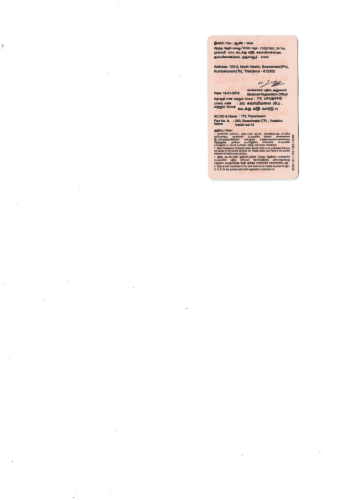

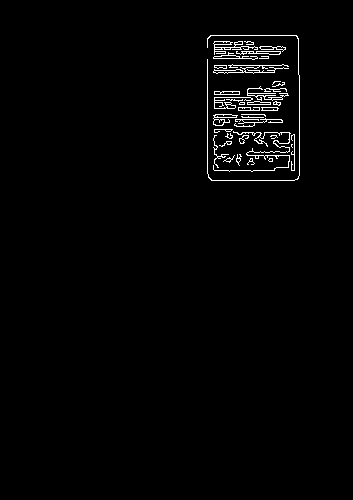

In [ ]:
# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/PyImageSearch/doc2.jpg")
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)
# show the original image and the edge detected image
print("STEP 1: Edge Detection")
cv2_imshow(image)
cv2_imshow(edged)
cv2.waitKey(0)
cv2.destroyAllWindows()

STEP 2: Find contours of paper


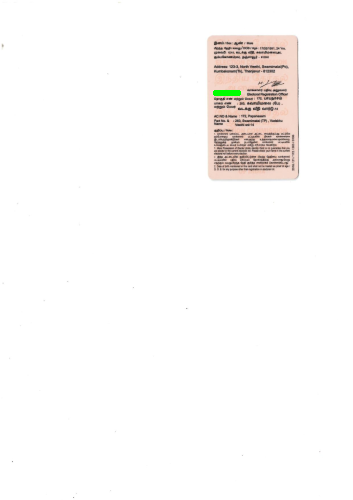

In [ ]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if our approximated contour has four points, then we
	# can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()